<a href="https://colab.research.google.com/github/rakshitha-sathyakumar/twitter-COVID-19-analysis/blob/master/TopicModelling/TopicModelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
# Installations
import sys
if 'google.colab' in sys.modules:
    !pip install pandas-profiling==2.* &> /dev/null
    !python -m spacy download en_core_web_lg &> /dev/null
    !pip install pyldavis &> /dev/null
    !pip install gensim &> /dev/null
    !pip install --upgrade autopep8 &> /dev/null

In [3]:
import json
import requests
import pandas as pd
import numpy as np
import re
from collections import Counter

#Visualizations
import seaborn as sns
import matplotlib.pyplot as plt 
import pyLDAvis.gensim

#Natural Language Processing (NLP)
import spacy
import gensim
from spacy.tokenizer import Tokenizer
from gensim.corpora import Dictionary
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
from gensim.parsing.preprocessing import STOPWORDS as SW
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint
from wordcloud import STOPWORDS
stopwords = set(STOPWORDS)

import os
os.environ['MALLET_HOME'] = '/content/mallet-2.0.8'
mallet_path = '/content/mallet-2.0.8/bin/mallet'  

import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


#tokenizing
import en_core_web_sm
nlp = en_core_web_sm.load()
from nltk.tokenize import word_tokenize

import nltk
nltk.download('punkt')



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

#Data Preprocessing

In [4]:
covid_data = pd.read_csv('/content/drive/My Drive/256 project/preprocessed_data.csv')

In [5]:
covid_data

,created_at,tweet_id,text,iso_language_code,result_type,source,user_id,user_name,user_location,users_followers_count,statuses_count,retweeted_text,retweet_count,hashtags,favorite_count,retweeted_status,url,clean_text
0,2020-07-10 05:49:12,1281465476191621122,How Can Accounting Software Reduce the Impact ...,en,recent,Twitter Web App,742999699272040449,📚RayvatAccounting.com,United States,1773,9613,How Can Accounting Software Reduce the Impact ...,0,Coronavirus,0,This is a retweet,This is a retweet,accounting software reduce impact coronavirus ...
1,2020-07-10 05:49:29,1281465544798085131,What people know and how they behave during CO...,en,recent,News Medical,39211040,News Medical,None,13293,54866,What people know and how they behave during CO...,0,Canada,1,This is a retweet,This is a retweet,people know behave covid19 canadian perspectiv...
2,2020-07-10 05:58:18,1281467763890860032,RT @Poorvika_Mobile: A silver lining amidst th...,en,recent,Twitter for Android,1250719740701491200,Subi,None,2,317,RT @Poorvika_Mobile: A silver lining amidst th...,932,"Poorvika_Mobiles, India",0,This is a retweet,This is a retweet,silver lining amidst chaoswe poorvikamobiles t...
3,2020-07-10 05:58:56,1281467923899580417,RT @gergerlioglueng: Harun Çümen (Balıkesir Pr...,en,recent,Twitter for Android,1242200819308662784,Gurbet,None,623,2722,RT @gergerlioglueng: Harun Çümen (Balıkesir Pr...,157,COVID19,0,This is a retweet,This is a retweet,harun cumen balikesir prison couldnt see kids ...
4,2020-07-10 06:00:00,1281468192125263873,Oximeters won't steal your fingerprints. Turni...,en,recent,TweetDeck,3780315496,International Fact-Checking Network,🌎 🌍 🌏,27111,11456,Oximeters won't steal your fingerprints. Turni...,6,None,6,This is a retweet,This is a retweet,oximeters wont steal fingerprints turning tech...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29140,2020-08-04 05:35:53,1290521819062165504,RT @CDWGWAGov: Emerging Technologies for Track...,en,recent,Twitter for addempsea,1196874000837816320,quotesBot,None,907,136081,RT @CDWGWAGov: Emerging Technologies for Track...,11,"pandemic, bigdata, datascience, analytics, ai,...",0,This is a retweet,This is a retweet,emerging technologies tracking covid19 pandemi...
29141,2020-08-04 05:35:58,1290521841157713920,RT @CDWGWAGov: Emerging Technologies for Track...,en,recent,nlognrobot,1260062769543434240,#100DaysOfCode,None,1435,187553,RT @CDWGWAGov: Emerging Technologies for Track...,11,"pandemic, bigdata, datascience, analytics, ai,...",0,This is a retweet,This is a retweet,emerging technologies tracking covid19 pandemi...
29142,2020-08-04 05:36:34,1290521991599009792,RT @CDWGWAGov: Emerging Technologies for Track...,en,recent,TheDataScienceBot,1276058041389953024,The Data Science Bot,None,588,57258,RT @CDWGWAGov: Emerging Technologies for Track...,11,"pandemic, bigdata, datascience, analytics, ai,...",0,This is a retweet,This is a retweet,emerging technologies tracking covid19 pandemi...
29143,2020-08-04 05:37:44,1290522287389605889,Wow! Spain &amp; France don’t have any new dai...,en,recent,Twitter for iPhone,3242523302,Stray Turtle,"California, USA",74,60615,Wow! Spain &amp; France don’t have any new dai...,0,None,0,This is a retweet,This is a retweet,wow spain amp france dont new daily cases that...


##Tokenization

In [6]:
word_tokens = []
for sent in covid_data['clean_text'].astype(str):
    # print(word_tokenize(sent))
    word_tokens.append(word_tokenize(sent))

In [7]:
covid_data['tokenized_text'] = word_tokens

##Lemmatization

In [8]:
# Make tokens a string again
covid_data['tokens_back_to_text'] = [' '.join(map(str, l)) for l in covid_data['tokenized_text']]


In [9]:
def get_lemmas(text):
    lemmas=[]
    doc = nlp(text)


    for token in doc:
        if((token.is_stop == False) and (token.is_punct==False)) and (token.pos_!='PRON'):
            lemmas.append(token.lemma_)
    return lemmas

covid_data['lemmas_tokens'] = covid_data['tokens_back_to_text'].apply(get_lemmas)

In [10]:
# Make lemmas a string again
covid_data['lemmas_back_to_text'] = [' '.join(map(str, lt)) for lt in covid_data['lemmas_tokens']]

In [11]:
covid_data

,created_at,tweet_id,text,iso_language_code,result_type,source,user_id,user_name,user_location,users_followers_count,statuses_count,retweeted_text,retweet_count,hashtags,favorite_count,retweeted_status,url,clean_text,tokenized_text,tokens_back_to_text,lemmas_tokens,lemmas_back_to_text
0,2020-07-10 05:49:12,1281465476191621122,How Can Accounting Software Reduce the Impact ...,en,recent,Twitter Web App,742999699272040449,📚RayvatAccounting.com,United States,1773,9613,How Can Accounting Software Reduce the Impact ...,0,Coronavirus,0,This is a retweet,This is a retweet,accounting software reduce impact coronavirus ...,"[accounting, software, reduce, impact, coronav...",accounting software reduce impact coronavirus ...,"[accounting, software, reduce, impact, coronav...",accounting software reduce impact coronavirus ...
1,2020-07-10 05:49:29,1281465544798085131,What people know and how they behave during CO...,en,recent,News Medical,39211040,News Medical,None,13293,54866,What people know and how they behave during CO...,0,Canada,1,This is a retweet,This is a retweet,people know behave covid19 canadian perspectiv...,"[people, know, behave, covid19, canadian, pers...",people know behave covid19 canadian perspectiv...,"[people, know, behave, covid19, canadian, pers...",people know behave covid19 canadian perspectiv...
2,2020-07-10 05:58:18,1281467763890860032,RT @Poorvika_Mobile: A silver lining amidst th...,en,recent,Twitter for Android,1250719740701491200,Subi,None,2,317,RT @Poorvika_Mobile: A silver lining amidst th...,932,"Poorvika_Mobiles, India",0,This is a retweet,This is a retweet,silver lining amidst chaoswe poorvikamobiles t...,"[silver, lining, amidst, chaoswe, poorvikamobi...",silver lining amidst chaoswe poorvikamobiles t...,"[silver, line, amidst, chaoswe, poorvikamobile...",silver line amidst chaoswe poorvikamobiles tha...
3,2020-07-10 05:58:56,1281467923899580417,RT @gergerlioglueng: Harun Çümen (Balıkesir Pr...,en,recent,Twitter for Android,1242200819308662784,Gurbet,None,623,2722,RT @gergerlioglueng: Harun Çümen (Balıkesir Pr...,157,COVID19,0,This is a retweet,This is a retweet,harun cumen balikesir prison couldnt see kids ...,"[harun, cumen, balikesir, prison, couldnt, see...",harun cumen balikesir prison couldnt see kids ...,"[harun, cumen, balikesir, prison, not, kid, mo...",harun cumen balikesir prison not kid month amp...
4,2020-07-10 06:00:00,1281468192125263873,Oximeters won't steal your fingerprints. Turni...,en,recent,TweetDeck,3780315496,International Fact-Checking Network,🌎 🌍 🌏,27111,11456,Oximeters won't steal your fingerprints. Turni...,6,None,6,This is a retweet,This is a retweet,oximeters wont steal fingerprints turning tech...,"[oximeters, wont, steal, fingerprints, turning...",oximeters wont steal fingerprints turning tech...,"[oximeter, will, not, steal, fingerprint, turn...",oximeter will not steal fingerprint turn techn...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29140,2020-08-04 05:35:53,1290521819062165504,RT @CDWGWAGov: Emerging Technologies for Track...,en,recent,Twitter for addempsea,1196874000837816320,quotesBot,None,907,136081,RT @CDWGWAGov: Emerging Technologies for Track...,11,"pandemic, bigdata, datascience, analytics, ai,...",0,This is a retweet,This is a retweet,emerging technologies tracking covid19 pandemi...,"[emerging, technologies, tracking, covid19, pa...",emerging technologies tracking covid19 pandemi...,"[emerge, technology, track, covid19, pandemic,...",emerge technology track covid19 pandemic bigda...
29141,2020-08-04 05:35:58,1290521841157713920,RT @CDWGWAGov: Emerging Technologies for Track...,en,recent,nlognrobot,1260062769543434240,#100DaysOfCode,None,1435,187553,RT @CDWGWAGov: Emerging Technologies for Track...,11,"pandemic, bigdata, datascience, analytics, ai,...",0,This is a retweet,This is a retweet,emerging technologies tracking covid19 pandemi...,"[emerging, technologies, tracking, covid19, pa...",emerging technologie

#Base Model

In [12]:
#Create a id2word dictionary
id2word = Dictionary(covid_data['lemmas_tokens'])
print(len(id2word))

20652


In [13]:
#Filtering Extremes
id2word.filter_extremes(no_below=2,no_above=0.99)
print(len(id2word))

11801


In [14]:
# Creating a corpus object 
corpus = [id2word.doc2bow(d) for d in covid_data['lemmas_tokens']]

In [15]:
#Instantiating a Base LDA model
base_model = LdaMulticore(corpus=corpus,num_topics=5,id2word=id2word,workers=12,passes=5)

In [16]:
#Filtering for words
words = [re.findall(r'"([^"]*)"',t[1]) for t in base_model.print_topics()]

In [17]:
#create topics
topics = [' '.join(t[0:10])for t in words]

In [18]:
#Getting the topics
for id,t in enumerate(topics):
    print(f"------Topic {id} -----")
    print(t,end="\n\n")

------Topic 0 -----
coronavirus covid19 case pandemic death read new report update cdc

------Topic 1 -----
covid19 coronavirus pandemic trump covid biden school amp test child

------Topic 2 -----
covid19 coronavirus pandemic wear mask health corona new socialdistancing common

------Topic 3 -----
covid19 coronavirus pandemic covid mask not work new trump quarantine

------Topic 4 -----
coronavirus pandemic covid19 read amp human know face live cdc



In [19]:
#compute perplexity
# a measure of how good the model is. lower the better
base_perplexity = base_model.log_perplexity(corpus)
print('\nPerplexity:', base_perplexity)

#compute coherence score
coherence_model = CoherenceModel(model=base_model,texts = covid_data['lemmas_tokens'],dictionary=id2word,coherence='c_v')
coherence_lda_model_base = coherence_model.get_coherence()
print('\nCoherence Score:',coherence_lda_model_base)


Perplexity: -7.339725032939336

Coherence Score: 0.25685033432443244


In [20]:
#Creating Topic Distance Visualization 
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(base_model, corpus, id2word)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.002117 -0.176544       1        1  26.925749
1      0.022238  0.093466       2        1  20.402748
3      0.026692  0.054293       3        1  20.303329
2     -0.175096  0.022480       4        1  16.983896
4      0.124049  0.006306       5        1  15.384277, topic_info=         Term          Freq         Total Category  logprob  loglift
79       case   2837.000000   2837.000000  Default  30.0000  30.0000
11    covid19  14721.000000  14721.000000  Default  29.0000  29.0000
273     death   1641.000000   1641.000000  Default  28.0000  28.0000
603     trump   1924.000000   1924.000000  Default  27.0000  27.0000
114      wear   1092.000000   1092.000000  Default  26.0000  26.0000
...       ...           ...           ...      ...      ...      ...
98        new    215.993103   2397.512207   Topic5  -5.2672  -0.5351
159     state    165.142700    645.906311   Topic5  -5.5356   0.5080
204      test    171.572235    906.426514   Topic5  -5.4975   0.2073
1749    story    148.517807    385.469360   Topic5  -5.6418   0.9181
243      take    132.900879    450.134033   Topic5  -5.7529   0.6519

[392 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
2434      1  0.035280    2019
2434      2  0.023520    2019
2434      3  0.035280    2019
2434      4  0.023520    2019
2434      5  0.881999    2019
...     ...       ...     ...
346       3  0.119805   world
346       4  0.105195   world
346       5  0.277598   world
4657      2  0.957392  xprize
4657      4  0.023351  xprize

[967 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 4, 3, 5])

#LDA model

In [21]:
vectorizer = CountVectorizer()
data_vectorized = vectorizer.fit_transform(covid_data['lemmas_back_to_text'])

In [22]:
#Search Param
params = {'n_components':[10,15,20,25,30],'learning_decay':[.5,.7,.9]}

#initialize the model
lda = LatentDirichletAllocation()

model = GridSearchCV(lda,param_grid=params)

model.fit(data_vectorized)
GridSearchCV(cv=None,error_score='raise',estimator=LatentDirichletAllocation(batch_size=128,doc_topic_prior=None,evaluate_every=1,learning_decay=0.7,
                                                  learning_method=None, learning_offset=10.0,
                                                  max_doc_update_iter=100,max_iter=10,
                                                   mean_change_tol=0.001, 
                                                 n_components=10, 
                                                 n_jobs=1,
                                                 perp_tol=0.1, 
                                                 random_state=None,
                                                 topic_word_prior=None, 
                                                 total_samples=1000000.0, 
                                                 verbose=0),
             iid=True, n_jobs=1,
             param_grid={'n_topics': [10, 15, 20, 30], 
                         'learning_decay': [0.5, 0.7, 0.9]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
             scoring=None, verbose=0)
                                                

GridSearchCV(cv=None, error_score='raise',
             estimator=LatentDirichletAllocation(batch_size=128,
                                                 doc_topic_prior=None,
                                                 evaluate_every=1,
                                                 learning_decay=0.7,
                                                 learning_method=None,
                                                 learning_offset=10.0,
                                                 max_doc_update_iter=100,
                                                 max_iter=10,
                                                 mean_change_tol=0.001,
                                                 n_components=10, n_jobs=1,
                                                 perp_tol=0.1,
                                                 random_state=None,
                                                 topic_word_prior=None,
                                                 total_s

In [23]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': 0.9, 'n_components': 10}
Best Log Likelihood Score:  -562718.7301772375
Model Perplexity:  1621.956976987953


In [24]:
#optimal number of topics
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values_topics = []
    model_topic_list = []
    for num_topics in range(start,limit,step):
        model = LdaMulticore(corpus=corpus,num_topics = num_topics,id2word=id2word)
        model_topic_list.append(model)
        coherencemodel = CoherenceModel(model = model,texts=texts,dictionary =dictionary,coherence='c_v')
        coherence_values_topics.append(coherencemodel.get_coherence())
    return model_topic_list, coherence_values_topics

In [25]:
model_topic_list, coherence_values_topic = compute_coherence_values(dictionary=id2word,
                                                        corpus=corpus,
                                                        texts=covid_data['lemmas_tokens'],
                                                        start=2, limit=200, step=6)

/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


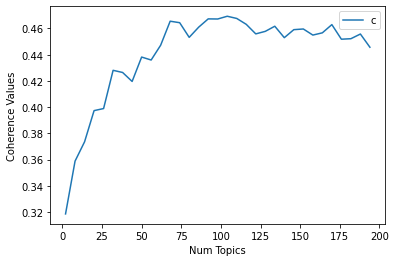

In [26]:
#graph
limit=200; start=2; step=6;
x=range(start,limit,step)
plt.plot(x, coherence_values_topic)
plt.xlabel('Num Topics')
plt.ylabel('Coherence Values')
plt.legend(("coherence_values"), loc='best')
plt.show()

In [27]:
for n, cv in zip(x, coherence_values_topic):
    print("Num Topics =", n, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3186
Num Topics = 8  has Coherence Value of 0.3589
Num Topics = 14  has Coherence Value of 0.3736
Num Topics = 20  has Coherence Value of 0.3974
Num Topics = 26  has Coherence Value of 0.3989
Num Topics = 32  has Coherence Value of 0.4281
Num Topics = 38  has Coherence Value of 0.4264
Num Topics = 44  has Coherence Value of 0.4196
Num Topics = 50  has Coherence Value of 0.4382
Num Topics = 56  has Coherence Value of 0.4359
Num Topics = 62  has Coherence Value of 0.4472
Num Topics = 68  has Coherence Value of 0.4655
Num Topics = 74  has Coherence Value of 0.4644
Num Topics = 80  has Coherence Value of 0.4532
Num Topics = 86  has Coherence Value of 0.461
Num Topics = 92  has Coherence Value of 0.4673
Num Topics = 98  has Coherence Value of 0.4672
Num Topics = 104  has Coherence Value of 0.4693
Num Topics = 110  has Coherence Value of 0.4676
Num Topics = 116  has Coherence Value of 0.4631
Num Topics = 122  has Coherence Value of 0.4559
Num Topics =

In [28]:
optimal_model = model_topic_list[13]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(11,
  '0.170*"vaccine" + 0.059*"coronavirus" + 0.059*"covid19" + 0.054*"idea" + '
  '0.041*"pandemic" + 0.038*"challenge" + 0.028*"trial" + 0.027*"academy" + '
  '0.027*"spokesperson" + 0.025*"volunteer"'),
 (39,
  '0.063*"melbourne" + 0.050*"congress" + 0.042*"covid19" + 0.042*"rate" + '
  '0.033*"office" + 0.032*"coronavirus" + 0.030*"covid" + 0.029*"expression" + '
  '0.029*"administration" + 0.027*"fast"'),
 (5,
  '0.096*"world" + 0.059*"start" + 0.052*"coronavirus" + 0.051*"police" + '
  '0.047*"man" + 0.030*"protest" + 0.025*"covid19" + 0.024*"free" + '
  '0.023*"north" + 0.022*"sakal"'),
 (20,
  '0.090*"talk" + 0.060*"ask" + 0.049*"coronavir" + 0.049*"pandemic" + '
  '0.043*"reason" + 0.032*"month" + 0.030*"covid19" + 0.029*"coronavirus" + '
  '0.023*"enter" + 0.022*"court"'),
 (40,
  '0.142*"death" + 0.073*"coronavirus" + 0.072*"toll" + 0.068*"case" + '
  '0.059*"covid19" + 0.038*"rise" + 0.027*"update" + 0.026*"new" + '
  '0.023*"head" + 0.021*"report"'),
 (66,
  '0.241*"car

In [29]:
model_lda = LdaMulticore(corpus=corpus,
                       id2word=id2word,
                       num_topics=74,
                       random_state=42,
                       chunksize=2000,
                       passes=25,
                       decay=0.5,
                       iterations=70)

In [30]:
# Filtering for words 
words = [re.findall(r'"([^"]*)"',t[1]) for t in model_lda.print_topics()]

In [31]:
# Create Topics
topics = [' '.join(t[0:10]) for t in words]

In [32]:
# Getting the topics
for id, t in enumerate(topics): 
    print(f"------ Topic {id} ------")
    print(t, end="\n\n")

------ Topic 0 ------
2020 coronavirus july covid19 come brazil update join russia india

------ Topic 1 ------
wear mask covid19 simple common facial maskmt coronavirus link trial

------ Topic 2 ------
covid19 quarantine pandemic coronavirus app article deal effect half morning

------ Topic 3 ------
comparison covid19 treatment coronavirus surpass drug write cancel level low

------ Topic 4 ------
vietnam family company covid19 fun quarantine meaningful journa coronavirus montreal

------ Topic 5 ------
begin pandemic art artist photography san archive wait photographer hotel

------ Topic 6 ------
state expert sell fake california benefit area covid19coronaviru push geographical

------ Topic 7 ------
call continue early testing flu provide result free industry staff

------ Topic 8 ------
force accord leader lead friday covid19 coronavirus responder origin corporate

------ Topic 9 ------
look like summer see try social essential predict distancing mask

------ Topic 10 ------
thi

In [33]:
# Compute Perplexity
# a measure of how good the model is. lower the better
model_perplexity = model_lda.log_perplexity(corpus)
print('\nPerplexity: ', model_perplexity) 

# Compute Coherence Score
coherence_model = CoherenceModel(model=model_lda, texts=covid_data['lemmas_tokens'], 
                                   dictionary=id2word, coherence='c_v')
coherence_lda_model_base = coherence_model.get_coherence()
print('\nCoherence Score: ', coherence_lda_model_base)


Perplexity:  -7.494793176177405

Coherence Score:  0.5168295066096583


In [34]:
#Creating Topic Distance Visualization 
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(model_lda, corpus, id2word)

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
0     -0.213523 -0.028167       1        1  4.106392
39    -0.011075 -0.298571       2        1  3.785102
47    -0.012200 -0.360623       3        1  3.537024
33    -0.030377 -0.221003       4        1  2.735430
17    -0.044319 -0.019840       5        1  2.148833
...         ...       ...     ...      ...       ...
4      0.021277 -0.039453      70        1  0.827161
62     0.088596  0.068215      71        1  0.798395
46     0.135405  0.072167      72        1  0.790512
36     0.151482  0.004187      73        1  0.749132
30     0.038920  0.094756      74        1  0.747796

[74 rows x 5 columns], topic_info=             Term          Freq         Total Category  logprob  loglift
79           case   2948.000000   2948.000000  Default  30.0000  30.0000
11        covid19  14474.000000  14474.000000  Default  29.0000  29.0000
74          covid   2383.000000   2383.000000  Default  28.0000  28.0000
98            new   2316.000000   2316.000000  Default  27.0000  27.0000
2     coronavirus  13592.000000  13592.000000  Default  26.0000  26.0000
...           ...           ...           ...      ...      ...      ...
345          time     36.020031    528.531250  Topic74  -4.0344   2.2098
11        covid19     59.551517  14474.983398  Topic74  -3.5316  -0.5975
3325       sunday     22.816116    111.528893  Topic74  -4.4910   3.3090
610          free     25.589022    229.065247  Topic74  -4.3763   2.7040
1400         fact     18.802090    104.270325  Topic74  -4.6845   3.1828

[2805 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
1710      37  0.989337     0000
10324     16  0.989727        1
1423      33  0.991557      100
244       59  0.991138     1000
3244       3  0.972611    10000
...      ...       ...      ...
3542       1  0.965419    youth
2466      59  0.966005  youtube
11476     71  0.899824      yyc
2501      53  0.960618     zero
1116      57  0.978179     zone

[2984 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 40, 48, 34, 18, 43, 21, 74, 69, 50, 70, 72, 3, 24, 8, 2, 30, 39, 25, 46, 51, 10, 68, 29, 32, 38, 52, 41, 35, 33, 6, 73, 44, 28, 20, 7, 57, 22, 67, 64, 15, 49, 27, 13, 45, 14, 16, 53, 54, 36, 62, 55, 42, 12, 4, 65, 11, 59, 71, 26, 9, 60, 58, 61, 23, 19, 17, 66, 56, 5, 63, 47, 37, 31])

# Topic Modelling using LDA-Mallet

In [38]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip  &> /dev/null
!unzip mallet-2.0.8.zip  &> /dev/null

In [39]:
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path,corpus=corpus,num_topics=74,id2word=id2word,workers = 4,iterations=1000)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [40]:
print(ldamallet.show_topics(formatted=False))

[(58, [('covid19', 0.2730313165095774), ('coronavirus', 0.2620857403466099), ('pandemic', 0.18242626938279113), ('testing', 0.053815749467923384), ('sign', 0.030100334448160536), ('deal', 0.028580115536637276), ('announce', 0.012465795074490726), ('tomorrow', 0.009121313469139556), ('universal', 0.006384919428397689), ('horror', 0.006080875646093037)]), (71, [('record', 0.10512483574244415), ('day', 0.10302233902759526), ('case', 0.09750328515111695), ('florida', 0.06307490144546649), ('report', 0.052562417871222074), ('death', 0.03810775295663601), ('break', 0.029960578186596584), ('coronavirusus', 0.02706964520367937), ('set', 0.025229960578186595), ('history', 0.01971090670170828)]), (6, [('sarscov2', 0.11279826464208242), ('pandemic', 0.06600557793616361), ('scientist', 0.048961884102881936), ('infection', 0.03594669972110319), ('immunity', 0.02479082739386427), ('worldwide', 0.022621629996901146), ('evidence', 0.021382088627207932), ('cell', 0.016114037806011776), ('damn', 0.01518

In [41]:
# Compute Coherence Score
coherence_model = CoherenceModel(model=ldamallet, texts=covid_data['lemmas_tokens'], 
                                   dictionary=id2word, coherence='c_v')
coherence_lda_model_base = coherence_model.get_coherence()
print('\nCoherence Score: ', coherence_lda_model_base)


Coherence Score:  0.37014031402179476


In [42]:
def convertldaMalletToldaGen(mallet_model):
    model_gensim = LdaMulticore(
        id2word=mallet_model.id2word, num_topics=mallet_model.num_topics,
        alpha=mallet_model.alpha) 
    model_gensim.state.sstats[...] = mallet_model.wordtopics
    model_gensim.sync_state()
    return model_gensim

In [43]:
ldagensim = convertldaMalletToldaGen(ldamallet)

In [44]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(ldagensim, corpus, id2word) 

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
54     0.103833 -0.052636       1        1  1.513595
4      0.121347 -0.007546       2        1  1.498487
14     0.144477 -0.042287       3        1  1.463183
63     0.180503 -0.005730       4        1  1.451451
19     0.176828 -0.031412       5        1  1.419521
...         ...       ...     ...      ...       ...
51    -0.086854  0.262353      70        1  1.319872
2     -0.302311  0.008205      71        1  1.319814
16     0.050087 -0.052428      72        1  1.318062
52    -0.055849 -0.131227      73        1  1.317245
64    -0.022472 -0.135051      74        1  1.297306

[74 rows x 5 columns], topic_info=              Term          Freq         Total Category  logprob  loglift
11         covid19  16417.000000  16417.000000  Default  30.0000  30.0000
2      coronavirus  15140.000000  15140.000000  Default  29.0000  29.0000
59        pandemic   9682.000000   9682.000000  Default  28.0000  28.0000
79            case   2860.000000   2860.000000  Default  27.0000  27.0000
4             read   2065.000000   2065.000000  Default  26.0000  26.0000
...            ...           ...           ...      ...      ...      ...
511      treatment     18.808170    181.851212  Topic74  -5.2351   2.0760
6504  surprisingly      2.832020      8.071202  Topic74  -7.1284   3.2976
6410          hack      2.832020     13.680970  Topic74  -7.1284   2.7699
11         covid19      2.832020  16417.384766  Topic74  -7.1284  -4.3202
166           week      1.892247    344.363983  Topic74  -7.5316  -0.8591

[3502 rows x 6 columns], token_table=       Topic      Freq         Term
term                               
1710       6  0.990940         0000
6524      28  0.939934         0503
4324      21  0.939888     07122020
10324     24  0.971526            1
1423       6  0.010827          100
...      ...       ...          ...
2466      23  0.960255      youtube
8590      38  0.802728  yurikokoike
2021      20  0.637236   zazzlemade
6447      45  0.938833        zelen
1116      68  0.972401         zone

[5443 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[55, 5, 15, 64, 20, 71, 61, 25, 27, 72, 23, 13, 14, 42, 49, 54, 43, 40, 21, 10, 22, 73, 34, 67, 74, 24, 4, 66, 26, 60, 68, 11, 35, 1, 36, 32, 45, 41, 57, 58, 69, 28, 59, 8, 38, 50, 46, 31, 16, 63, 62, 56, 51, 6, 47, 39, 19, 37, 2, 33, 9, 70, 30, 18, 12, 48, 7, 29, 44, 52, 3, 17, 53, 65])